# IT 7143 Project - Group 2

### House Property Sales Analysis

#### Abstract

The purpose of the project is to analyze the house property sales over the time. Apart from that, Anomaly Detection and Forecasting were also performed on the Sales Price of the house using different SKLearn and AWS Models.

## <font color = 'red'>Regression</font>

In [1]:
import pandas as pd
import numpy as np 

In [2]:
data = pd.read_csv('raw_sales.csv')
data['datesold'] = pd.to_datetime(data['datesold']).astype(str)
data['datesold'] = data['datesold'].str.replace('-','').astype(int)
data

,datesold,postcode,price,propertyType,bedrooms
0,20070207,2607,525000,house,4
1,20070227,2906,290000,house,3
2,20070307,2905,328000,house,3
3,20070309,2905,380000,house,4
4,20070321,2906,310000,house,3
...,...,...,...,...,...
29575,20190725,2900,500000,unit,3
29576,20190725,2612,560000,unit,2
29577,20190726,2912,464950,unit,2
29578,20190726,2601,589000,unit,2


In [3]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

#split = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=10)

for train_index, test_index in split.split(data, data['postcode']):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

#for train_index, test_index in split.split(data):
#    train_set = data.loc[train_index]
#    test_set = data.loc[test_index]

In [4]:
trainX = train_set.drop('price',axis=1)
trainY = train_set['price']
testX = test_set.drop('price',axis=1)
testY = test_set['price']

trainX.shape, testX.shape, trainY.shape, testY.shape

((22185, 4), (7395, 4), (22185,), (7395,))

Matplotlib is building the font cache; this may take a moment.


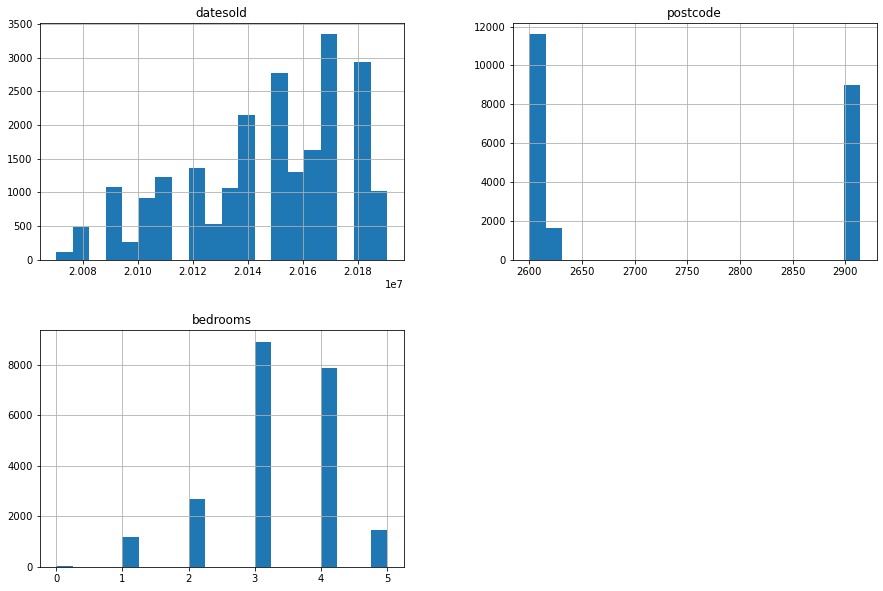

In [5]:
from matplotlib import pyplot as plt

trainX.hist(bins=20, figsize=(15,10))
plt.show()

In [6]:
trainY.describe()

count    2.218500e+04
mean     6.092549e+05
std      2.784414e+05
min      5.650000e+04
25%      4.400000e+05
50%      5.510000e+05
75%      7.050000e+05
max      8.000000e+06
Name: price, dtype: float64

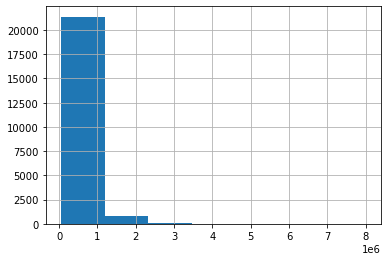

In [7]:
trainY.hist(bins=7)
plt.show()

#### Using standard pipeline for Standardization and One Hot Encoding.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

num_cols = trainX.columns[(trainX.dtypes==np.int64)]

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

cat_cols = trainX.columns[trainX.dtypes==object]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encode', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, num_cols),
    ('class', cat_pipeline, cat_cols)
])

In [9]:
trainX_prc = full_pipeline.fit_transform(trainX)
traindata = np.concatenate([trainY.values.reshape(-1,1),trainX_prc],axis=1)
pd.DataFrame(traindata).to_csv('train.csv', index=False, header=False)


testX_prc = full_pipeline.transform(testX)
testdata = np.array(testX_prc)

### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

linear_reg = LinearRegression()
linear_reg.fit(trainX_prc,trainY)

#get the prediction
trainY_pred = linear_reg.predict(trainX_prc)
testY_pred = linear_reg.predict(testX_prc)

#get the MSE
train_mse_lr = mean_squared_error(trainY, trainY_pred)
test_mse_lr = mean_squared_error(testY, testY_pred)
print('training MSE:', train_mse_lr)
print('testing MSE:', test_mse_lr)

training MSE: 50537045955.96455
testing MSE: 56028678006.04244


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

lin_reg = LinearRegression()
lin_reg.fit(trainX_prc, trainY)

#get training accuracy
train_accuracy_ln = lin_reg.score(trainX_prc, trainY)

#get testing accuracy
test_accuracy_ln = lin_reg.score(testX_prc, testY)

print('Training Accuracy:', train_accuracy_ln)
print('Testing Accuracy:', test_accuracy_ln)

Training Accuracy: 0.3481287263526407
Testing Accuracy: 0.3396389753087887


### Decision Tree Regressor

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [5, 7, 9],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX_prc,trainY)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1000 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 1315, in fit
    super().fit(
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 308, in fit
    

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [5, 7, 9],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='r2')

In [13]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 10, 'min_samples_split': 40}
0.5918829701062042


In [14]:
best_dt = grid_search.best_estimator_
best_dt.score(testX_prc, testY)

0.5763631867718085

## AWS Model

### XGBoost

In [15]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [17]:
bucket_name = 'regression-bucket-project'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [18]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [19]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='reg:linear',num_round=100)

In [20]:
xgb.fit({'train': s3_input_train})

2022-07-31 22:07:51 Starting - Starting the training job...ProfilerReport-1659305270: InProgress
...
2022-07-31 22:08:33 Starting - Preparing the instances for training.........
2022-07-31 22:10:14 Downloading - Downloading input data...
2022-07-31 22:10:50 Training - Downloading the training image......
2022-07-31 22:11:45 Training - Training image download completed. Training in progress..Arguments: train
[2022-07-31:22:11:48:INFO] Running standalone xgboost training.
[2022-07-31:22:11:48:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-07-31:22:11:48:INFO] File size need to be processed in the node: 1.59mb. Available memory size in the node: 8470.24mb
[2022-07-31:22:11:48:INFO] Determined delimiter of CSV input is ','
[22:11:48] S3DistributionType set as FullyReplicated
[22:11:48] 22185x5 matrix with 110925 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[22:11:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra node

#### Deploy the model

In [21]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

----------!

#### Prepare the test data

In [22]:
testY = pd.DataFrame(testY)

#### Test the Trained XGBoost Model

In [23]:
from sagemaker.serializers import CSVSerializer

xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(testX_prc).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(7395,)


#### Testing the accuracy

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# evaluate predictions
predictions_rouded = np.round(predictions_array)
accuracy = accuracy_score(testY, predictions_rouded)
print("XGBoost Testing Accuracy: %.2f%%" % (accuracy * 100.0))

#get the MSE
test_mse_xgb = mean_squared_error(testY, predictions_rouded)
print('Testing MSE:', test_mse_xgb)

XGBoost Testing Accuracy: 0.00%
Testing MSE: 31909955577.802433


#### Clean-up

In [25]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'EQCQH2EEJYY4ZC7P',
   'HostId': '6a/5st2CrQfS5zCc/jtdwCumMTTPnDuEfsjhh03+mtQxXpvps/2wYtfsOOZqziissQ5VIJjbCBc=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': '6a/5st2CrQfS5zCc/jtdwCumMTTPnDuEfsjhh03+mtQxXpvps/2wYtfsOOZqziissQ5VIJjbCBc=',
    'x-amz-request-id': 'EQCQH2EEJYY4ZC7P',
    'date': 'Sun, 31 Jul 2022 22:18:52 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-07-31-22-07-50-961/rule-output/ProfilerReport-1659305270/profiler-output/profiler-report.html'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-07-31-22-07-50-961/rule-output/ProfilerReport-1659305270/profiler-output/profiler-reports/BatchSize.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-07-31-22-07-50-961/rule-output/ProfilerReport-1659305270/profiler-output/profile

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## <font color = 'red'>Anomaly Detection</font>

In [26]:
%matplotlib notebook 
import numpy as np
import pandas as pd
from matplotlib import dates
import matplotlib.pyplot as plt

#### Load data

In [27]:
df_unsorted = pd.read_csv('raw_sales.csv')
df_unsorted['datesold'] = pd.to_datetime(df_unsorted['datesold'])
df_unsorted

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3
...,...,...,...,...,...
29575,2019-07-25,2900,500000,unit,3
29576,2019-07-25,2612,560000,unit,2
29577,2019-07-26,2912,464950,unit,2
29578,2019-07-26,2601,589000,unit,2


In [28]:
# Sorting the dataframe based on postal code and date so that consecutive rows will have data for same postal code
df = df_unsorted.sort_values(by=['postcode', 'datesold'],ignore_index=True)

# Adding a new column (prev_price) to the dataframe that will contain previous date's hone price.
# This is achived by shifting the rows for price column by 1
# The first record for each postal code will have prev_price = NaN since it does not have a previous date's price to compare
df['prev_price'] = np.where(df['postcode'].shift(1) != df['postcode'],  np.NaN, df['price'].shift(1))

# Dropping all the records with prev_price = NaN since we cannot use them to find anomalies
df = df.dropna(subset=['prev_price'])

# Restting the sort order back to date sold inorder to better plot the graphs
df = df.sort_values(by=['datesold'],ignore_index=True)
df

,datesold,postcode,price,propertyType,bedrooms,prev_price
0,2007-03-09,2905,380000,house,4,328000.0
1,2007-03-21,2906,310000,house,3,290000.0
2,2007-04-04,2905,465000,house,4,380000.0
3,2007-04-24,2607,399000,house,3,525000.0
4,2007-05-25,2906,320000,house,3,310000.0
...,...,...,...,...,...,...
29548,2019-07-26,2612,775000,unit,2,560000.0
29549,2019-07-26,2601,589000,unit,2,590000.0
29550,2019-07-27,2615,647500,house,4,470000.0
29551,2019-07-27,2905,610000,house,4,510000.0


#### Plotting the Price Difference feature. The y-axis represents the price difference, and the x-axis represents datesold.

<IPython.core.display.Javascript object>


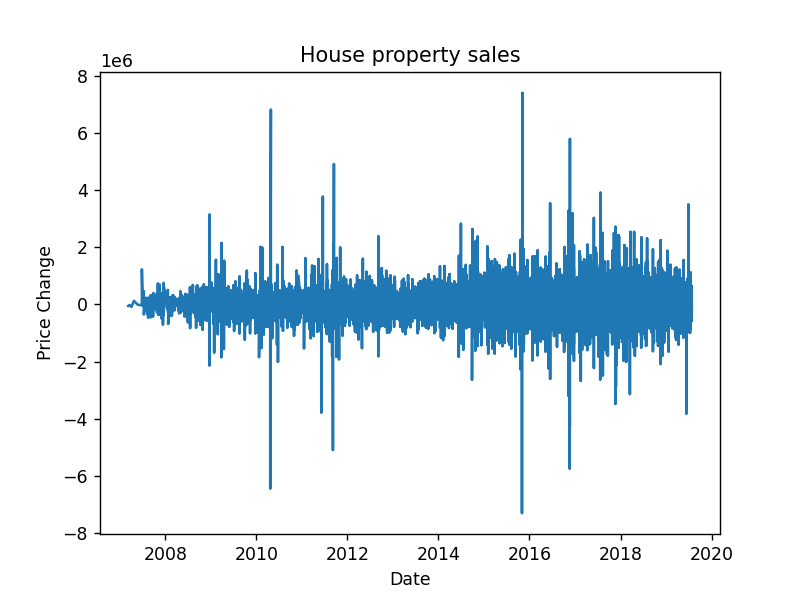

In [29]:
df['price_diff'] = df['prev_price'] - df['price']
plt.plot(df['datesold'], df['price_diff'])
#plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.title("House property sales")

plt.show()

#### Candlestick plot to illustrate price change data

<IPython.core.display.Javascript object>


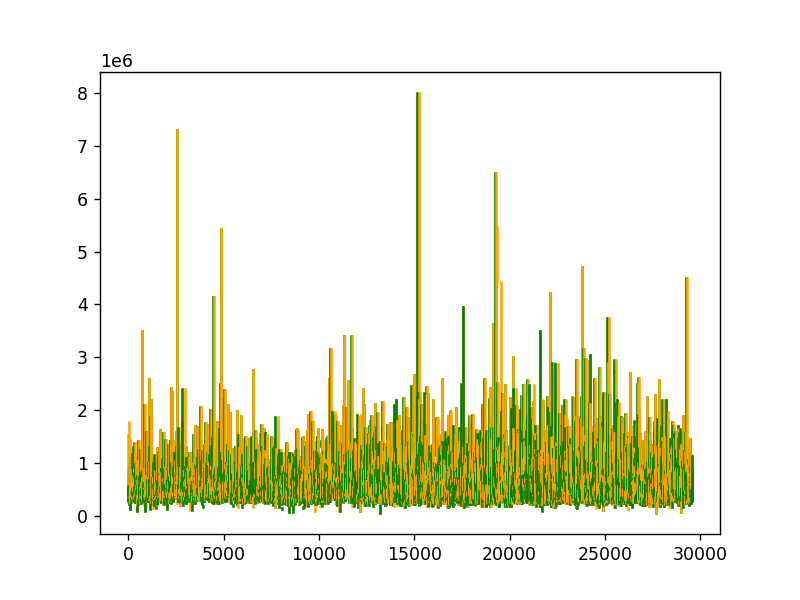

In [30]:
for d in range(df.shape[0]):
    if df['price'][d] < df['prev_price'][d]:
        c = 'orange'
    else:
        c = 'green'
    plt.plot([d,d],[df['price'][d],df['prev_price'][d]],color=c)
    
plt.show()

#### Finding the difference in price for consecutive dates.

In [31]:
X = df[['price_diff']].values
X_diff = np.diff(X,axis=0)
X_diff.shape

(29552, 1)

### Sklearn Models

### 1. Isolation Forest

In [32]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.02).fit(X_diff)
y_if = clf.predict(X_diff)
values, counts = np.unique(y_if, return_counts=True)

In [33]:
if_anomaly_prec = counts[0]/counts[1]*100
print('Isolation Forest Anomaly Percentage = ', round(if_anomaly_prec, 2), '%')

Isolation Forest Anomaly Percentage =  2.04 %


<IPython.core.display.Javascript object>


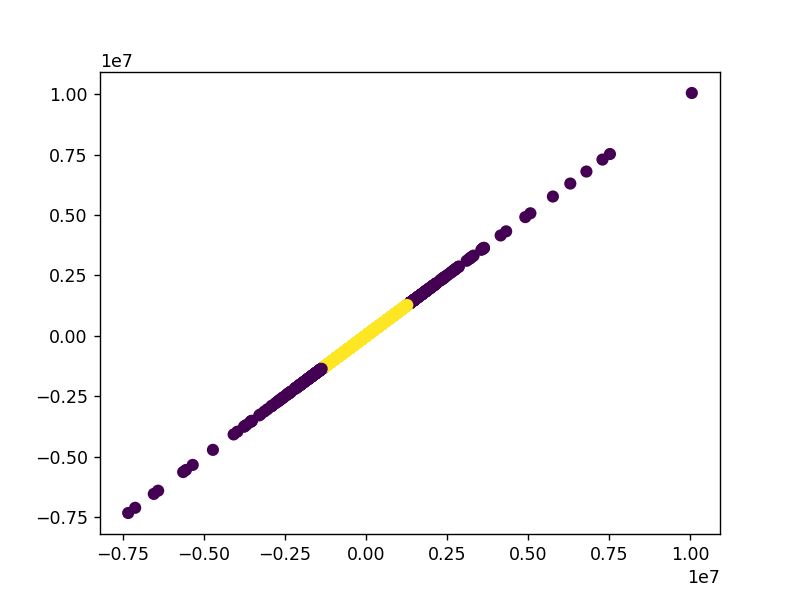

In [34]:
plt.scatter(X_diff[:,0],X_diff[:,0],c=y_if)
plt.show()

#### Scatter plot using previous days difference in price

<IPython.core.display.Javascript object>


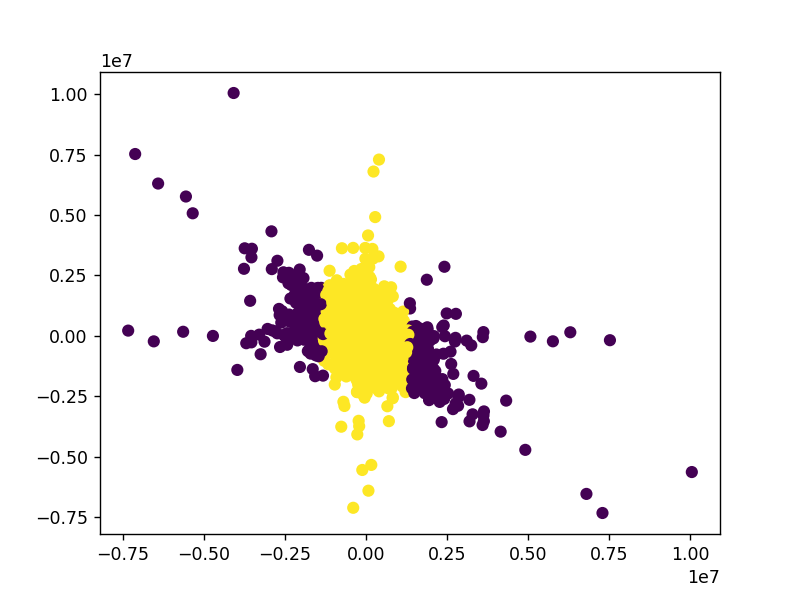

In [35]:
plt.scatter(X_diff[:(len(X_diff) - 1),0],X_diff[1:,0],c=y_if[:(len(X_diff) - 1)])
plt.show()

#### 2. Local Outlier Factor

In [36]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=50)
y_lof = lof.fit_predict(X_diff)
values, counts = np.unique(y_lof, return_counts=True)

In [37]:
lof_anomaly_prec = counts[0]/counts[1]*100
print('Local Outlier Factor Anomaly Percentage = ', round(lof_anomaly_prec, 2), '%')

Local Outlier Factor Anomaly Percentage =  4.65 %


<IPython.core.display.Javascript object>


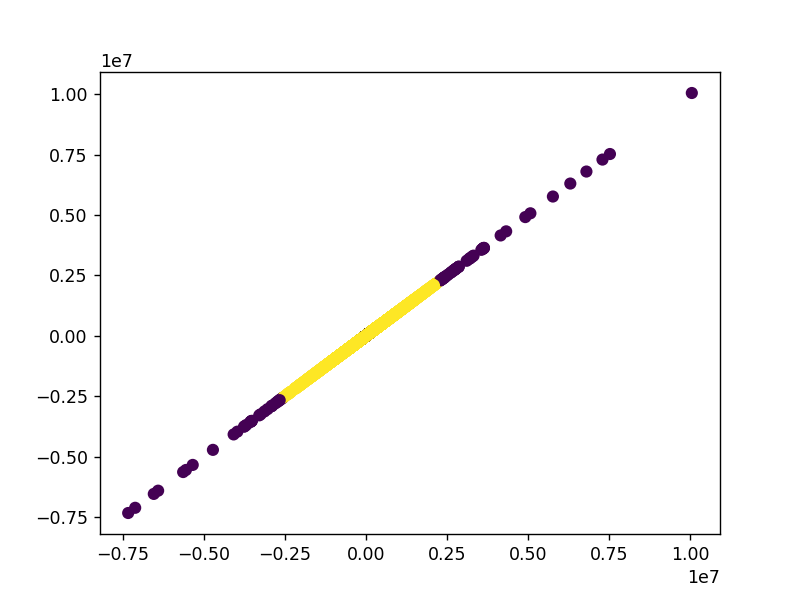

In [38]:
plt.scatter(X_diff[:,0],X_diff[:,0],c=y_lof)
plt.show()

#### Scatter plot using previous days difference in price

<IPython.core.display.Javascript object>


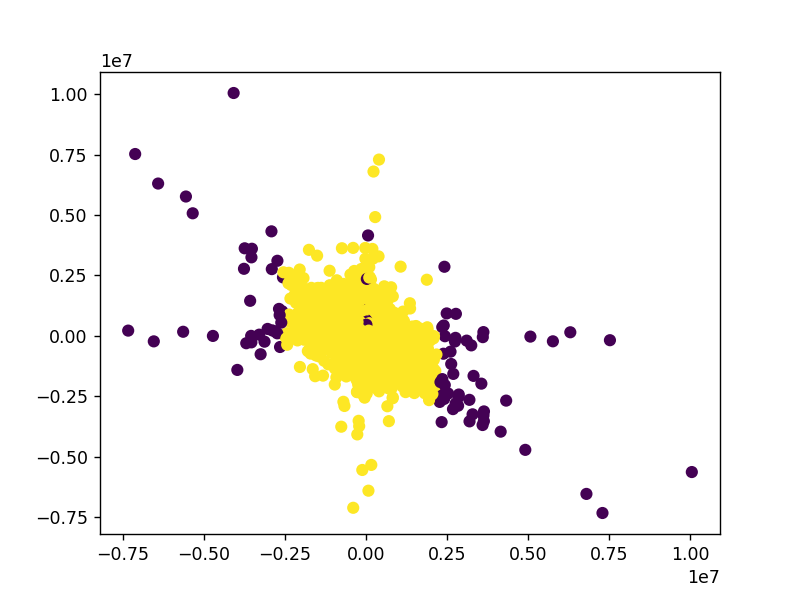

In [39]:
plt.scatter(X_diff[:(len(X_diff) - 1),0],X_diff[1:,0],c=y_lof[:(len(X_diff) - 1)])
plt.show()

### AWS Model

#### Setting up the environment

In [40]:
import sagemaker
import boto3
from time import gmtime, strftime
import os
from sagemaker import get_execution_role

region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

role = get_execution_role()
print(role)

sess = sagemaker.Session()

arn:aws:iam::532990456042:role/service-role/AmazonSageMaker-ExecutionRole-20220628T212650


#### Creating S3 bucket

In [42]:
bucket_name = 'anomaly-bucket-finalproject'
prefix = 'DEMO-anomaly-detection'

s3 = boto3.resource('s3')
try:
    if  region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


### Random Cut Forest Model

In [43]:
from sagemaker import RandomCutForest

rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket_name}/{prefix}/",
    output_path=f"s3://{bucket_name}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

#### Training the model

In [44]:
rcf.fit(rcf.record_set(X_diff))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-07-31 22:22:34 Starting - Starting the training job...
2022-07-31 22:22:59 Starting - Preparing the instances for trainingProfilerReport-1659306154: InProgress
.........
2022-07-31 22:24:26 Downloading - Downloading input data...
2022-07-31 22:24:58 Training - Downloading the training image......
2022-07-31 22:25:58 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/31/2022 22:26:07 INFO 140075293194048] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[07/31/2022 22:26:07 INFO 140075293194048

#### Deploying the model

In [46]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
results = rcf_inference.predict(X_diff)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------!

In [47]:
scores = np.array([d.label['score'].float32_tensor.values for d in results]).flatten()
score_mean = np.mean(scores)
score_std = np.std(scores)

score_cutoff = score_mean + 3.5*score_std
anomalies = np.ones(X_diff.shape[0])
anomalies[scores > score_cutoff] = -1

In [48]:
values, counts = np.unique(anomalies, return_counts=True)
aws_anomaly_prec = counts[0]/counts[1]*100
print('AWS Anaomaly Percentage = ', round(aws_anomaly_prec, 2), '%')

AWS Anaomaly Percentage =  1.19 %


<IPython.core.display.Javascript object>


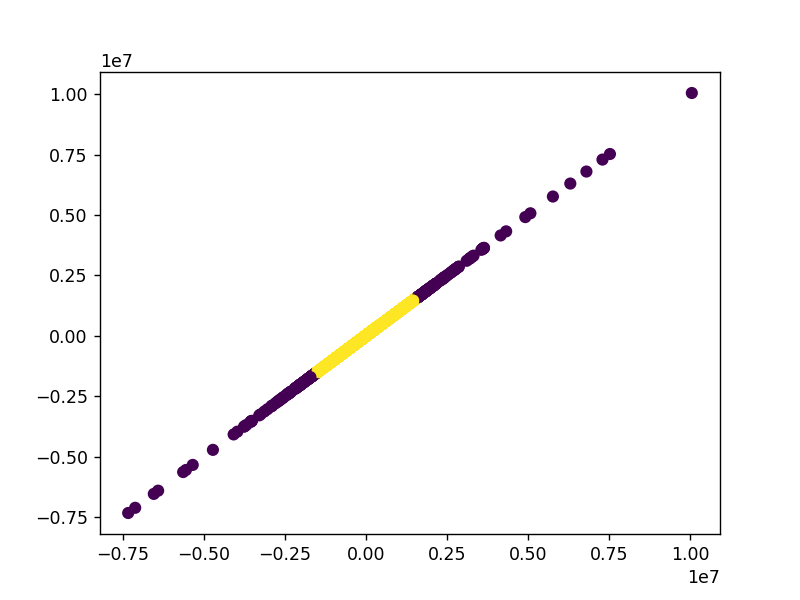

In [49]:
plt.scatter(X_diff[:,0],X_diff[:,0],c=anomalies)
plt.show()

#### Scatter plot

<IPython.core.display.Javascript object>


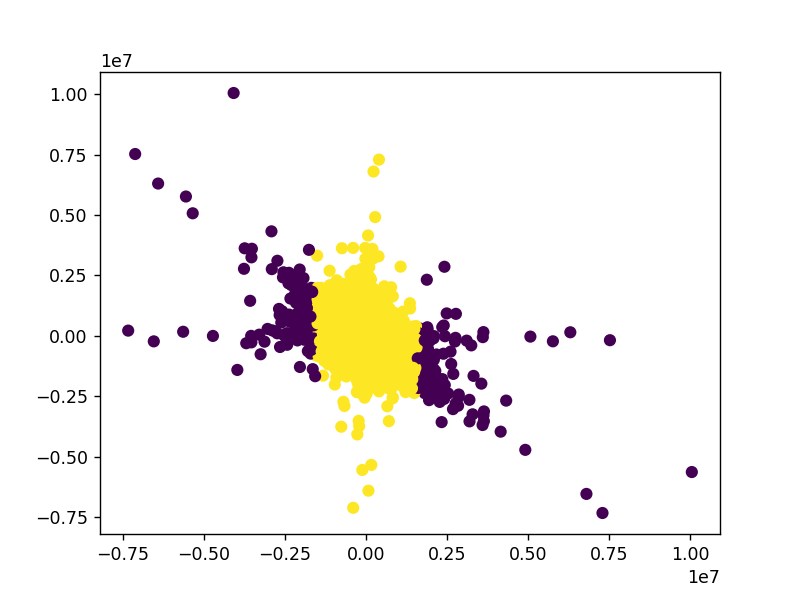

In [50]:
plt.scatter(X_diff[:(len(X_diff) - 1),0],X_diff[1:,0],c=anomalies[:(len(X_diff) - 1)])
plt.show()

#### Clean-up

In [51]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


[{'ResponseMetadata': {'RequestId': 'A5ABYNEBE6GK7PT1',
   'HostId': '+IV9ZDg5dBmCv5E0NJHYjqoMf3MXXMMt5mwpHEJQwpUtjy6oOridrEsCwE3yd0/JQLd3ctrlgGA=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': '+IV9ZDg5dBmCv5E0NJHYjqoMf3MXXMMt5mwpHEJQwpUtjy6oOridrEsCwE3yd0/JQLd3ctrlgGA=',
    'x-amz-request-id': 'A5ABYNEBE6GK7PT1',
    'date': 'Sun, 31 Jul 2022 22:35:05 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'DEMO-anomaly-detection/output/randomcutforest-2022-07-31-22-22-34-227/profiler-output/system/incremental/2022073122/1659306240.algo-1.json'},
   {'Key': 'DEMO-anomaly-detection/output/randomcutforest-2022-07-31-22-22-34-227/rule-output/ProfilerReport-1659306154/profiler-output/profiler-reports/LowGPUUtilization.json'},
   {'Key': 'DEMO-anomaly-detection/output/randomcutforest-2022-07-31-22-22-34-227/rule-output/ProfilerReport-1659306154/profil

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## <font color = 'red'>Forecasting</font>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
sales = pd.read_csv('raw_sales.csv')
sales

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
...,...,...,...,...,...
29575,2019-07-25 00:00:00,2900,500000,unit,3
29576,2019-07-25 00:00:00,2612,560000,unit,2
29577,2019-07-26 00:00:00,2912,464950,unit,2
29578,2019-07-26 00:00:00,2601,589000,unit,2


<IPython.core.display.Javascript object>


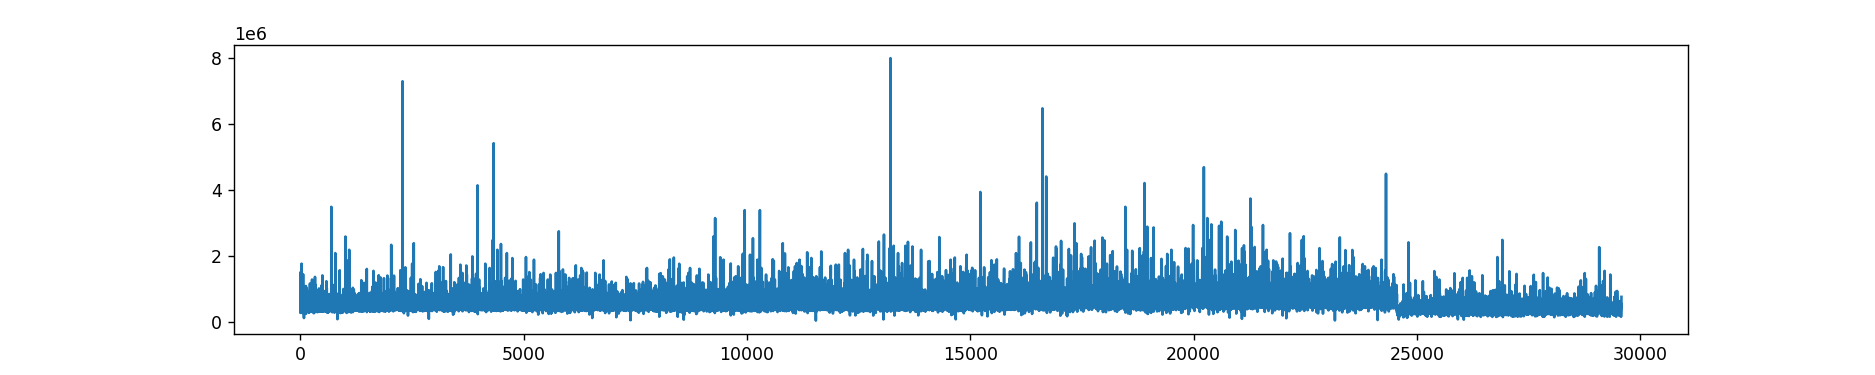

In [54]:
plt.figure(figsize=(15,3))
plt.plot(sales['price'])
plt.show()

In [55]:
sales_series=sales['price'].values

In [56]:
window=5 

X=np.array([sales_series[i:i+window].flatten() for i in range(sales_series.shape[0]-window)])
X.shape

(29575, 5)

In [57]:
y=sales_series[window:]
y.shape

(29575,)

In [58]:
X

array([[525000, 290000, 328000, 380000, 310000],
       [290000, 328000, 380000, 310000, 465000],
       [328000, 380000, 310000, 465000, 399000],
       ...,
       [321000, 380000, 475000, 500000, 560000],
       [380000, 475000, 500000, 560000, 464950],
       [475000, 500000, 560000, 464950, 589000]])

In [59]:
y.reshape(-1,1)

array([[ 465000],
       [ 399000],
       [1530000],
       ...,
       [ 464950],
       [ 589000],
       [ 775000]])

In [60]:
trainX = X[:2000]
trainY = y[:2000]
testX = X[2000:]
testY = y[2000:]
trainX.shape, trainY.shape, testX.shape, testY.shape

((2000, 5), (2000,), (27575, 5), (27575,))

### Support Vector Machine

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='r2')

In [62]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
-0.0819437198187051


In [63]:
best_svr = grid_search.best_estimator_
best_svr.score(testX, testY)

-0.2821318253673877

### Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='r2')

In [65]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 40, 'min_samples_split': 2}
0.03275987792239352


In [66]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

-0.054998910157354475

### Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

param_grid = [{
    'n_estimators' : [5, 10, 20, 50],
    'max_depth': [3,4,5],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 4, 5], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40],
                          'n_estimators': [5, 10, 20, 50]}],
             return_train_score=True, scoring='r2')

In [68]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.06211830822339746


In [69]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.03572911397261436